## Results of the experiments

![image](results.jpg)

## Loading Python modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

In [3]:
petal_data = pd.read_csv("Quantifications.csv")
petal_data.columns = ["Petal","Size","Lesion","Compound","Repeat"]
petal_data.replace({"Rep1": 1,"Rep2": 2,"Rep3": 3}, inplace = True)
petal_data.head()

,Petal,Size,Lesion,Compound,Repeat
0,1,11.160,1.155,Acetone,1
1,1,11.160,0.770,Coniferyl alcohol,1
2,2,13.537,0.716,Acetone,1
3,2,13.537,0.798,Coniferyl alcohol,1
4,3,11.886,0.779,Acetone,1


In [4]:
from patsy import dmatrices
y, X = dmatrices('Lesion ~ Compound', data=petal_data, return_type='dataframe')
X.columns = ["Intercept","Caffeic_ac", "Cinnamic_ac", "Coniferyl_alc", "Ethanol", "Ferulic_ac", "Sinapic_ac", "p-Coumaric_ac"]
X.head()

,Intercept,Caffeic_ac,Cinnamic_ac,Coniferyl_alc,Ethanol,Ferulic_ac,Sinapic_ac,p-Coumaric_ac
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model
$y_{ijr} \sim N(X_{i} \times \beta + \alpha^{petal}_{j}, \sigma^{2}) \\
\alpha^{petal}_{j} \sim N(\alpha^{repeat}_{r}, \sigma_{petal}^{2})\\
\alpha^{repeat}_{r} \sim N(0, \sigma_{repeat}^{2})$

In [5]:
petal_code = """
data {
    int<lower=0> N; // number of observations
    vector[N] y; // lesion size
    
    int<lower=0> K; // number of treatments + intercept
    matrix[N,K] X; // treatment matrix
    
    int<lower=0> Npet; // number of petals
    int pp [N]; // petal ids
    
    int<lower=0> Nrep; // number of experiments
    int rr [Npet]; // experiment id
}
parameters {
    real<lower=0> sigma;
    real<lower=0> sigma_pet;
    real<lower=0> sigma_rep;
    vector[Npet] alpha_pet_raw;
    vector[Nrep] alpha_rep_raw;
    vector[K] beta;
    }
transformed parameters {
    vector[Nrep] alpha_rep;
    vector[Npet] alpha_pet;
    alpha_rep = alpha_rep_raw * sigma_rep;
    alpha_pet = alpha_rep[rr] + alpha_pet_raw * sigma_pet;
}
model {
    sigma_rep ~ cauchy (0, 2.5);
    alpha_rep_raw ~ normal (0, 1);
    sigma_pet ~ cauchy (0, 2.5);
    alpha_pet_raw ~ normal (0, 1);
    beta ~ normal(0, 1);
    sigma ~ cauchy (0, 2.5);
    
    y ~ normal(X * beta + alpha_pet[pp], sigma);
}
"""

petal_dat = {'N': petal_data.shape[0],
           'y': petal_data["Lesion"],
           'K': X.shape[1],
           'X': X,
           'Npet': max(petal_data["Petal"]),
           'pp': petal_data["Petal"],
           'Nrep': max(petal_data["Repeat"]),
           'rr': petal_data[["Repeat", "Petal"]].drop_duplicates()["Repeat"]}

sm = pystan.StanModel(model_code=petal_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f928c20881185e9992dc2cd31785db86 NOW.


In [6]:
sm

In [10]:
fit = sm.sampling(data=petal_dat, n_jobs = 1, verbose = True)

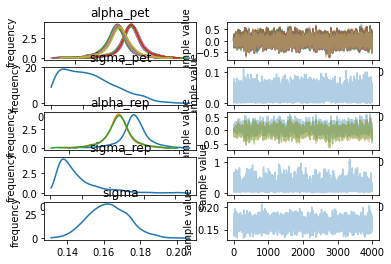

In [12]:
fit.plot(["alpha_pet", "sigma_pet", "alpha_rep", "sigma_rep", "sigma"]);

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

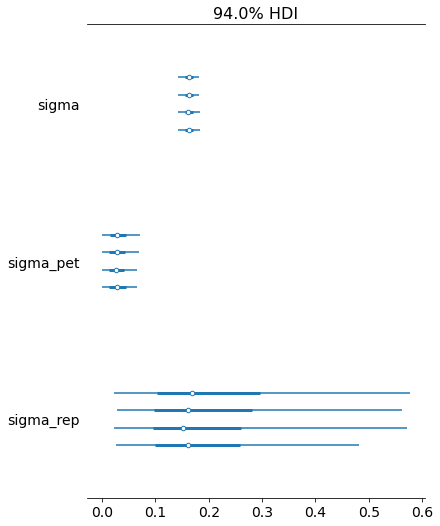

In [13]:
import arviz as avz
avz.plot_forest(fit, var_names=["sigma", "sigma_pet", "sigma_rep"])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

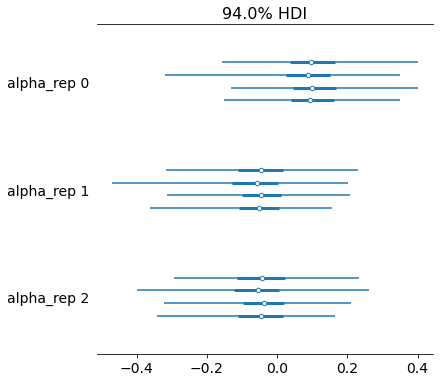

In [14]:
avz.plot_forest(fit, var_names=["alpha_rep"])

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

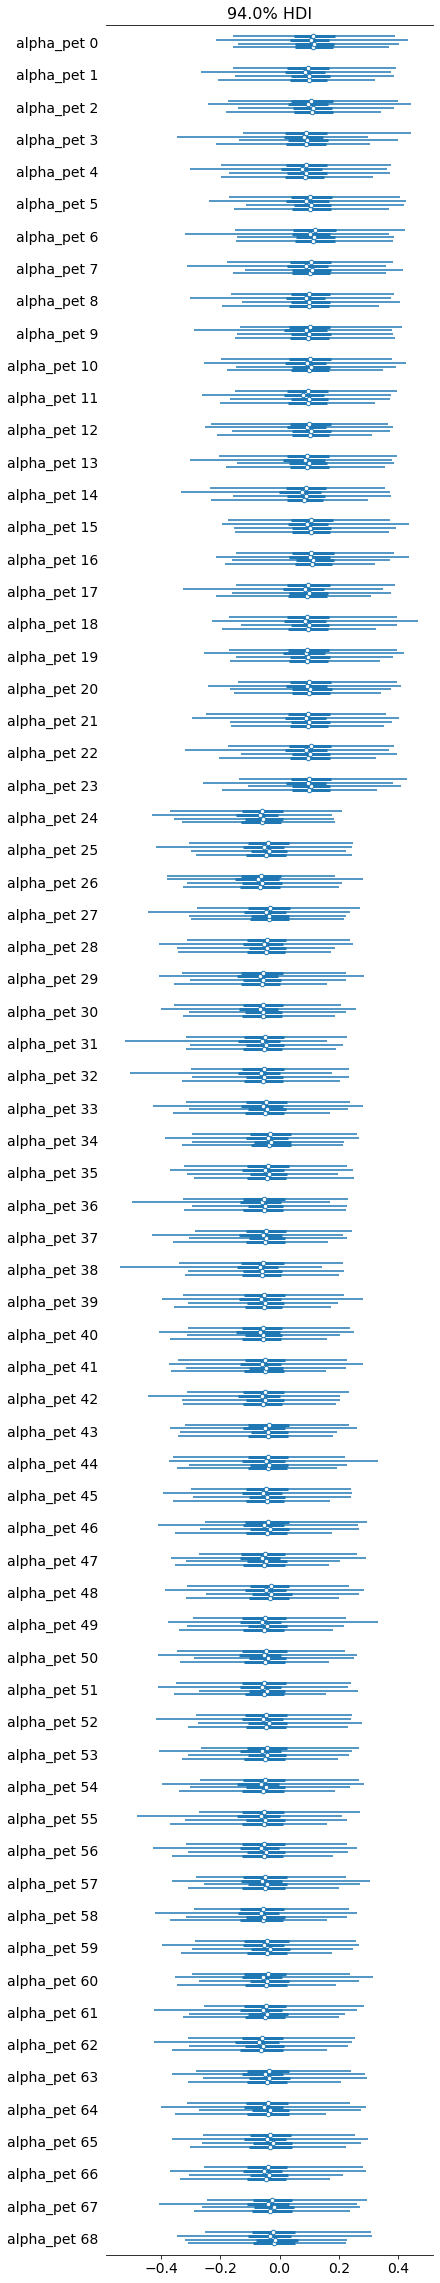

In [15]:
avz.plot_forest(fit, var_names=["alpha_pet"])

In [13]:
fit_df = fit.to_dataframe()
fit_df.head()

,chain,draw,warmup,sigma,sigma_pet,sigma_rep,alpha_pet_raw[1],alpha_pet_raw[2],alpha_pet_raw[3],alpha_pet_raw[4],...,alpha_pet[67],alpha_pet[68],alpha_pet[69],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,0.184288,0.017692,0.055711,0.155834,-0.141198,-0.210960,0.393551,...,-0.046425,-0.020878,-0.028901,139.124991,0.993087,0.033241,7,127,0,-96.227771
1,0,1,0,0.147467,0.012910,0.141833,1.159828,0.286269,2.042480,-1.934402,...,-0.121140,-0.130810,-0.116580,133.893638,0.990085,0.033241,7,127,0,-92.404242
2,0,2,0,0.175916,0.024020,0.588714,0.313788,0.030278,-1.825297,1.783484,...,0.042421,0.071229,0.041771,131.433547,0.991352,0.033241,7,127,0,-90.131314
3,0,3,0,0.185500,0.011296,0.578322,0.940758,-0.130664,-0.875275,1.638453,...,-0.125839,-0.129683,-0.122792,132.494684,0.994794,0.033241,7,127,0,-92.323306
4,0,4,0,0.144538,0.005474,0.325864,-1.207653,0.523775,1.003941,-1.991316,...,-0.050900,-0.053397,-0.053791,129.960988,0.998963,0.033241,7,127,0,-86.181983


In [14]:
fit_df2 = pd.melt(fit_df, id_vars = ["chain","draw","warmup"],
                  value_vars = ["beta[1]","beta[2]", "beta[3]", 
                                "beta[4]","beta[5]","beta[6]", 
                                "beta[7]", "beta[8]"], 
                  value_name = "value", var_name = "pars")
print(fit_df2)

       chain  draw  warmup     pars     value
0          0     0       0  beta[1]  0.691385
1          0     1       0  beta[1]  0.734287
2          0     2       0  beta[1]  0.801177
3          0     3       0  beta[1]  0.906762
4          0     4       0  beta[1]  0.721486
...      ...   ...     ...      ...       ...
31995      3   995       0  beta[8] -0.602776
31996      3   996       0  beta[8] -0.533934
31997      3   997       0  beta[8] -0.552358
31998      3   998       0  beta[8] -0.597364
31999      3   999       0  beta[8] -0.662678

[32000 rows x 5 columns]


([<matplotlib.axis.YTick at 0x7fca9f1e96a0>,
 [Text(0, 0, 'Intercept'),
  Text(0, 1, 'Caffeic_ac'),
  Text(0, 2, 'Cinnamic_ac'),
  Text(0, 3, 'Coniferyl_alc'),
  Text(0, 4, 'Ethanol'),
  Text(0, 5, 'Ferulic_ac'),
  Text(0, 6, 'Sinapic_ac'),
  Text(0, 7, 'p-Coumaric_ac')])

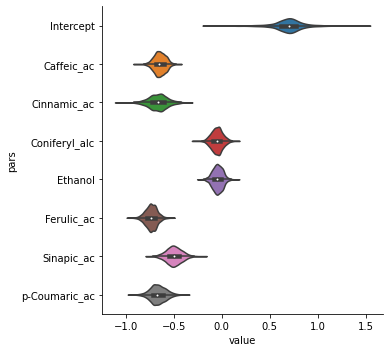

In [15]:
sns.catplot(data = fit_df2, x = "value", y = "pars",
            alpha = 0.1, kind = "violin")
loc, lab = plt.yticks()
lab = X.columns
plt.yticks(loc, lab)
